# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from scipy.stats.mstats import pearsonr, spearmanr
import pywt
idx = pd.IndexSlice
%matplotlib inline


# To investigate

1. Find all the high alpha stocks in this time period
    * Define what it would look like if we bought the avg market index and the cumulative return 
    * Rank the cumulative returns of the stocks

# Prepare training dataframe

In [2]:
prices_import=pd.read_csv("train_files/stock_prices.csv", parse_dates=['Date'])
stock_list=pd.read_csv("stock_list.csv")

print("The train data begins on {} and ends on {}.\n".format(prices_import.Date.min(),prices_import.Date.max()))
display(prices_import.describe().style.format('{:,.2f}'))

prices =prices_import.rename({'SecuritiesCode':'Code'}, axis = 1).set_index(keys = ['Code', 'Date']).sort_index().copy()
dates = prices.index.get_level_values(1).unique()
securities = prices.index.get_level_values(0).unique()

The train data begins on 2017-01-04 00:00:00 and ends on 2021-12-03 00:00:00.



,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,Target
count,"2,332,531.00","2,324,923.00","2,324,923.00","2,324,923.00","2,324,923.00","2,332,531.00","2,332,531.00","18,865.00","2,332,293.00"
mean,"5,894.84","2,594.51","2,626.54","2,561.23","2,594.02","691,936.56",1.00,22.02,0.00
std,"2,404.16","3,577.19","3,619.36","3,533.49","3,576.54","3,911,255.94",0.07,29.88,0.02
min,"1,301.00",14.00,15.00,13.00,14.00,0.00,0.10,0.00,-0.58
25%,"3,891.00","1,022.00","1,035.00","1,009.00","1,022.00","30,300.00",1.00,5.00,-0.01
50%,"6,238.00","1,812.00","1,834.00","1,790.00","1,811.00","107,100.00",1.00,15.00,0.00
75%,"7,965.00","3,030.00","3,070.00","2,995.00","3,030.00","402,100.00",1.00,30.00,0.01
max,"9,997.00","109,950.00","110,500.00","107,200.00","109,550.00","643,654,000.00",20.00,"1,070.00",1.12


## Filter out late IPOs
Stocks that IPO'd in the middle of the time period of the dataset won't be trained on

In [3]:
# Check if each security has a complete date set
date_set = (prices.groupby('Code', group_keys=False).apply(lambda x: dates.isin(x.index.get_level_values(1)).all()))
bad_securities = date_set[~date_set].index
good_securities = date_set[date_set].index

prices = prices.loc[good_securities].copy()

## Appending the market index 
The index I'll use is NIKKEI 400 which has a securities code:1592.  It's located in the secondary training set

<Axes: xlabel='Date', ylabel='Close'>

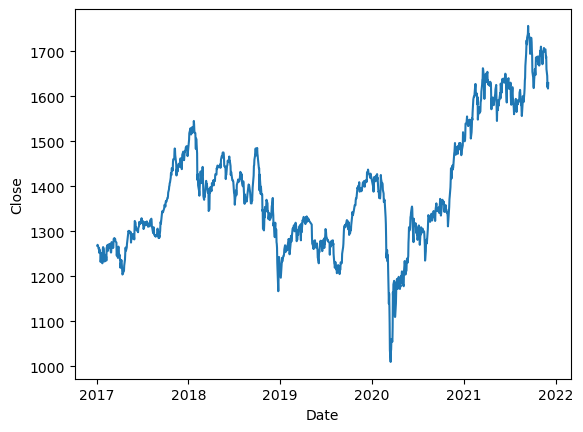

In [4]:
sec_stats = pd.read_csv('stock_list.csv').rename({'SecuritiesCode':'Code'}, axis = 1).set_index('Code')

secondar_prices_import = pd.read_csv('train_files/secondary_stock_prices.csv').rename({'SecuritiesCode':'Code'}, axis = 1)
secondar_prices_import.Date = pd.to_datetime(secondar_prices_import.Date)
secondar_prices_import = secondar_prices_import.set_index(['Code', 'Date']).sort_index()

prices = pd.concat([prices, secondar_prices_import.loc[idx[1592, :],:]]).sort_index()
market_df = prices.loc[1592]

fig, ax = plt.subplots()
sns.lineplot(data = market_df, x='Date', y='Close')

## Merging fundamental data
not working at the moment because of forecast revisions

In [5]:
fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})
fund_import = fund_import[~fund_import['Code'].isna()]
fund_import['Code']=fund_import['Code'].astype(int)
fund_import['Date'] = pd.to_datetime(fund_import['Date'])
fund_import = fund_import.set_index(['Code', 'Date']).sort_index()

quarterly_report_features = [
    'TypeOfDocument',
    'EarningsPerShare', 
    'Equity', 'EquityToAssetRatio', 'TotalAssets',
    'NetSales',
    'OperatingProfit', 'OrdinaryProfit', 'Profit', 
    'BookValuePerShare', 
    'ResultDividendPerShare1stQuarter',
    'ResultDividendPerShare2ndQuarter',
    'ResultDividendPerShare3rdQuarter',
    'ResultDividendPerShareAnnual',
    'ResultDividendPerShareFiscalYearEnd',
]

forecasted_fundamental_features =[
    'ForecastDividendPerShare1stQuarter',
    'ForecastDividendPerShare2ndQuarter',
    'ForecastDividendPerShare3rdQuarter',
    'ForecastDividendPerShareFiscalYearEnd',
    'ForecastNetSales',
    'ForecastOperatingProfit',
    'ForecastOrdinaryProfit',
    'ForecastProfit',
    'ForecastEarningsPerShare'
]
fundamental_features = quarterly_report_features + forecasted_fundamental_features
fund_import[fundamental_features[1:]]= fund_import[fundamental_features[1:]].apply(pd.to_numeric, errors='coerce')
fundamental = fund_import[fundamental_features]

/tmp/ipykernel_11585/1836249592.py:1: DtypeWarning: Columns (14,15,16,17,18,19,42,44) have mixed types. Specify dtype option on import or set low_memory=False.
  fund_import = pd.read_csv('train_files/financials.csv').rename(columns ={'SecuritiesCode': 'Code'})


In [6]:
fund_dup = fund_import.index[fund_import.index.duplicated()]
# fund_import.loc[fund_dup[6], :].T

In [7]:
# train = prices.join(fundamental, how = 'left')
# train[fundamental_features[1:]] = train[fundamental_features[1:]].ffill()
train = prices.copy()

In [8]:
train_dup = train.index[train.index.duplicated()]
# train.loc[train_dup[7]].T
# train.loc[train_dup, 'TypeOfDocument'].value_counts()
# display(train.loc[idx[1301, '2018-02-09'], :].index)

## Filtering out bad days
there was some bizarre outage on 2020-10-01


In [9]:
train = train[train.index.get_level_values(1) != '2020-10-01']

# for entries with no volume, make the OHLC the previous days close
# I'll probably throw these examples out since there's no actvitiy here
no_volume = train['Volume'] ==0
# train['Close'] =train.groupby('Code')['Close'].bfill()
# train.loc[no_volume, ['Open', 'High', 'Low']] = train.loc[no_volume, 'Close']

# Calculating targets

## Adjusted close and cumulative returns

In [10]:
train['AdjClose'] =train.groupby('Code', group_keys=False).apply(lambda x: x['Close']*(x['AdjustmentFactor'].cumprod()))
train['AdjVolume'] =train.groupby('Code', group_keys=False).apply(lambda x: x['Volume']/(x['AdjustmentFactor'].cumprod()))

# there are some bad reporting days that cause the returns to be incorrect
# In the original kaggle challenge the target was returns shifted ahead by 2 days, so I'll just shift those back by 2
train['returns'] = train.groupby('Code', group_keys=False)['Target'].shift(2)
# train['returns'] = train.groupby('Code', group_keys=False)['AdjClose'].apply(lambda x: x.pct_change())
train['cum_return'] = train.groupby('Code', group_keys=False)['returns'].apply(lambda x: (1+x).cumprod())


In [11]:
# forecast window
window = 45
forward_window = pd.api.indexers.FixedForwardWindowIndexer(window_size=window)

def wavelet_smooth(signal, threshold = 0.2, level =3, wavelet = 'db6'):

    coeff = pywt.wavedec(signal, wavelet, mode = 'per', level =level)
    coeff[1:]  = [pywt.threshold(i, value=threshold*np.abs(signal.max()), mode = 'soft') for i in coeff[1:]]
    clean_signal = pywt.waverec(coeff, wavelet, mode = 'per')
    # return clean_signal
    if len(signal)%2 == 1:
        clean_series= pd.Series(clean_signal[:-1], signal.index)
    else:
        clean_series =  pd.Series(clean_signal, signal.index)
    return clean_series

In [12]:
train['covar_i']=train.groupby('Code', group_keys=False)['Target'].apply(lambda x: x*market_df.Target)
train['covar'] =train.groupby('Code', group_keys=False)['covar_i'].rolling(window = forward_window).mean().droplevel(0).ffill()
train['beta'] = train.groupby('Code', group_keys=False)['covar'].apply(lambda x: x/train.loc[1592, 'covar'])
# train['dbeta'] = train.groupby('Code', group_keys=False)['beta'].apply(
#     lambda x: pd.Series(np.gradient(x), x.index))
train['dbeta'] = train.groupby('Code', group_keys=False)['beta'].apply(lambda x: x.diff().fillna(x.diff().mean()))
train['dbeta_sm']=train.groupby('Code', group_keys = False)['dbeta'].apply(wavelet_smooth, level = 4, threshold = 0.15)



In [13]:
train.loc[train.index.duplicated()]
train.loc[idx[1301, '2018-02-09'], :]


RowId               20180209_1301
Open                       3800.0
High                       3865.0
Low                        3770.0
Close                      3810.0
Volume                      72200
AdjustmentFactor              1.0
ExpectedDividend              NaN
SupervisionFlag             False
Target                   0.001353
AdjClose                   3810.0
AdjVolume                 72200.0
returns                 -0.019305
cum_return               1.391527
covar_i                  -0.00001
covar                    0.000066
beta                     0.634931
dbeta                   -0.062642
dbeta_sm                -0.032568
Name: (1301, 2018-02-09 00:00:00), dtype: object

<Axes: xlabel='dbeta_sm', ylabel='Count'>

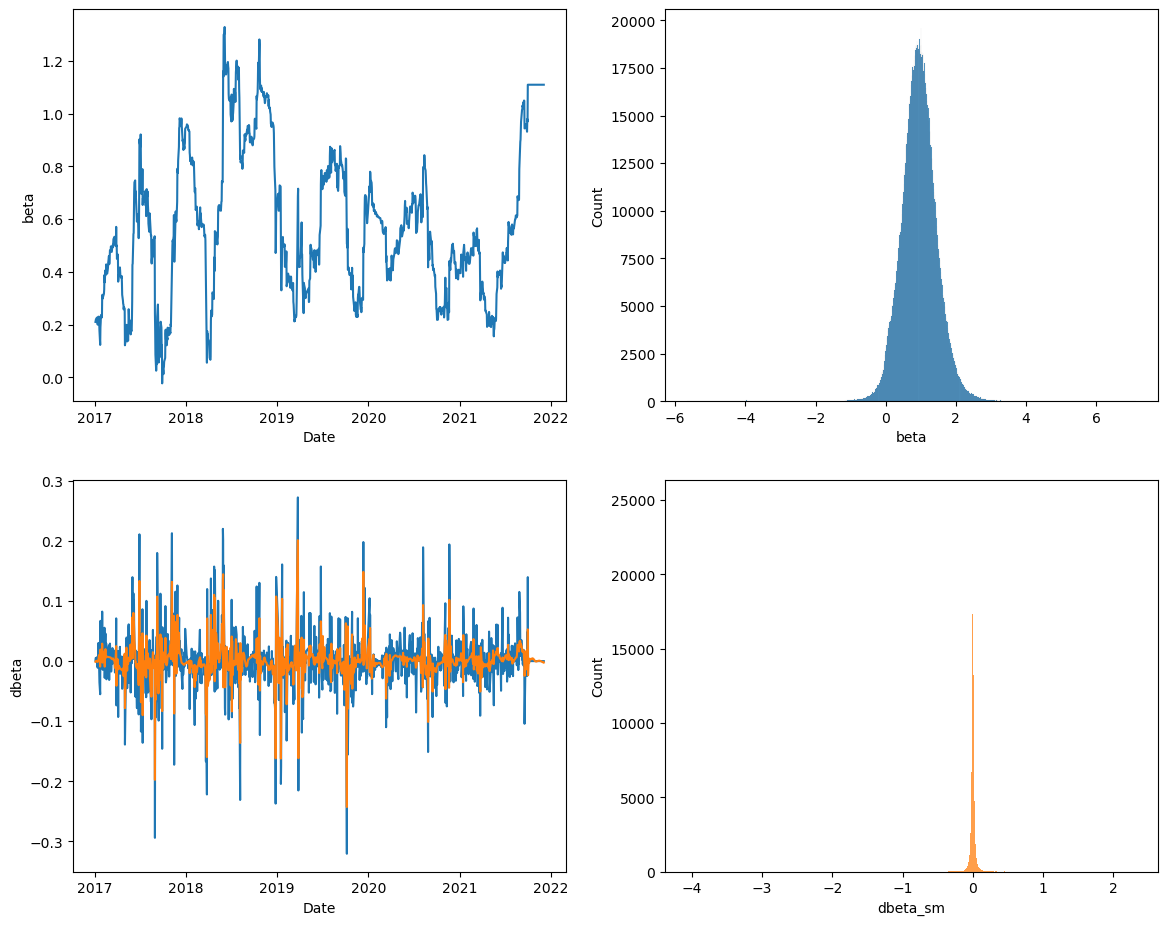

In [14]:
df = train.loc[1301]

fig, ax = plt.subplots(figsize = (14, 5.6*2), nrows = 2, ncols = 2)

sns.lineplot(df, x='Date', y = 'beta', ax = ax[0,0])
sns.histplot(train, x='beta', ax = ax[0,1])
sns.lineplot(df, x='Date', y = 'dbeta', ax = ax[1,0])
sns.lineplot(df, x='Date', y = 'dbeta_sm', ax = ax[1,0])
sns.histplot(train, x='dbeta_sm', ax = ax[1,1], color ='tab:orange')

In [15]:
# train['covar_1']=train[::-1].groupby('Code', group_keys=False)['covar_i'].rolling(window).mean().sort_index().droplevel(0).ffill()
# train['covar_2'] =train.groupby('Code', group_keys=False)['covar_i'].rolling(window = forward_window).mean().droplevel(0).ffill()
# train['covar_3'] = train.groupby('Code', group_keys=False)['covar_i'].rolling(window = window).mean().shift(-window).ffill().droplevel(0)
# df = train.loc[9997]

# fig, ax = plt.subplots()

# sns.lineplot(df, x='Date', y = 'covar')
# sns.lineplot(df, x = 'Date', y = 'covar_1')
# sns.lineplot(df, x = 'Date', y = 'covar_2')
# sns.lineplot(df, x = 'Date', y = 'covar_3')

## Calculate target alpha
Take a 45 period rolling average of the future 5 day returns

In [16]:
# train['returns_5d'] = train.groupby('Code', group_keys=False)['cum_return'].apply(lambda x: x.pct_change(-1)).ffill()
train['returns_45avg'] =train.groupby('Code', group_keys=False)['Target'].rolling(forward_window).mean().droplevel(0).ffill()
train['alpha'] = train.groupby('Code', group_keys=False).apply(lambda x: x.returns_45avg-train.loc[1592, 'returns_45avg'])

In [17]:
# train['cum_alpha'] =train.groupby('Code', group_keys=False)['alpha'].apply(lambda x: (x+1).cumprod())

In [18]:
# df = train.loc[1301]

# fig, ax = plt.subplots(figsize = (14, 5.6*2), nrows = 2, ncols = 2)

# sns.lineplot(df, x='Date', y = 'alpha', ax = ax[0,0])
# # sns.histplot(train, x='alpha', ax = ax[0,1])
# # sns.lineplot(df, x='Date', y = 'dbeta', ax = ax[1,0])
# # sns.lineplot(df, x='Date', y = 'dbeta_sm', ax = ax[1,0])
# # sns.histplot(train, x='dbeta_sm', ax = ax[1,1], color ='tab:orange')

## Look at the top 3 and bottom 3 beta stocks

In [19]:
sec_stats = pd.DataFrame(index = train.index.get_level_values(0).unique())
sec_stats['avg_alpha'] = train.groupby('Code', group_keys=False)['alpha'].mean()
sec_stats['alpha_rank'] = np.abs(sec_stats.avg_alpha).rank(ascending = False)
sec_stats['avg_beta'] = train.groupby('Code', group_keys=False)['beta'].mean()
sec_stats['beta_rank'] = np.abs(sec_stats.avg_beta).rank(ascending = False)
sec_stats.sort_values(by = 'beta_rank',inplace=True)


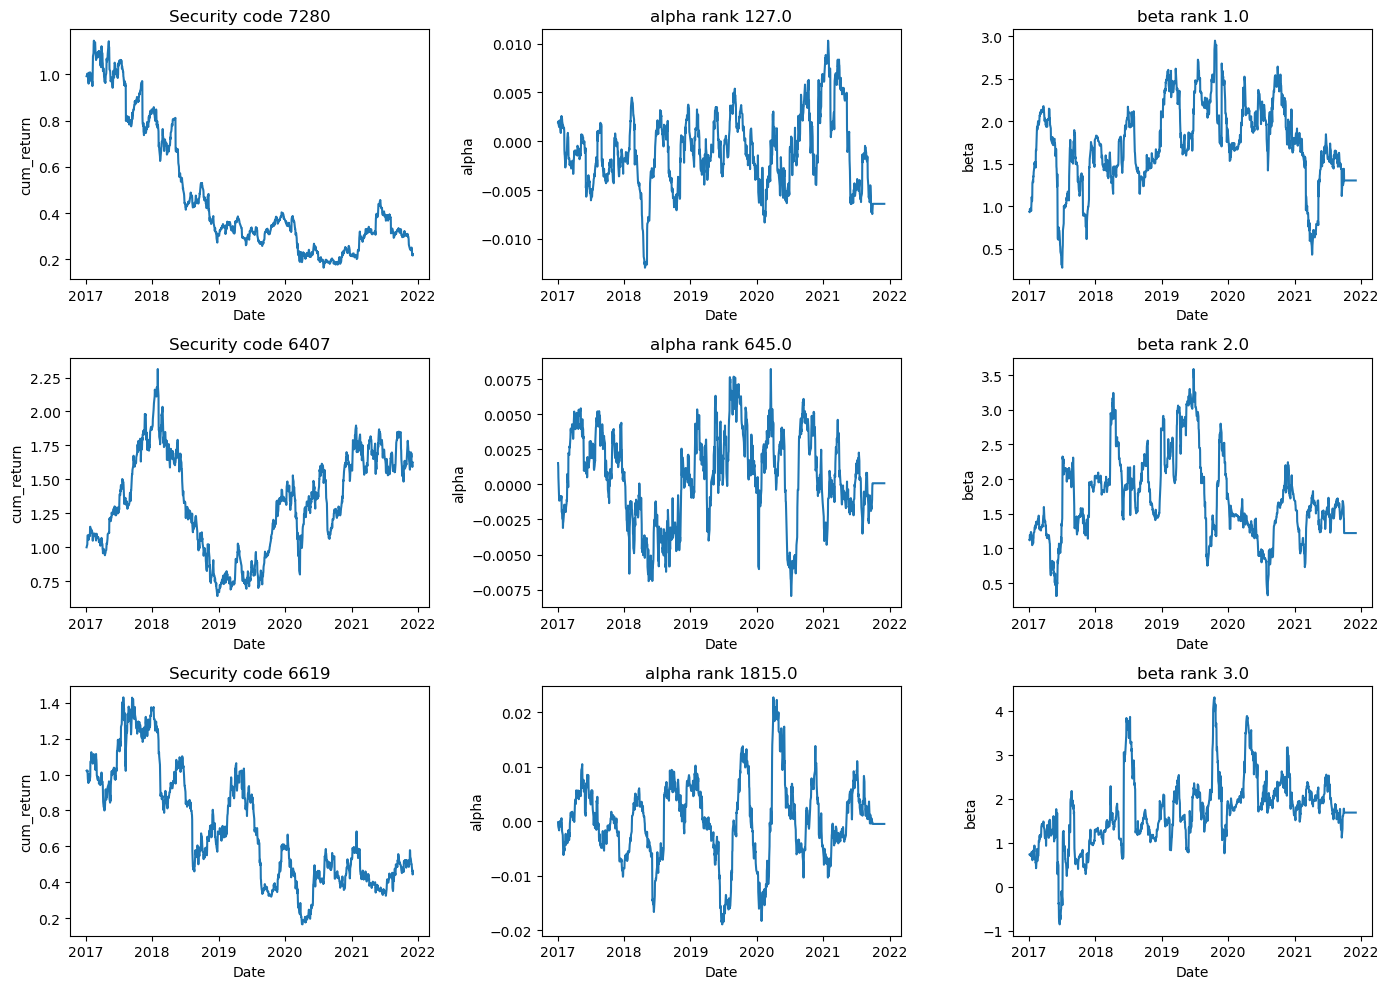

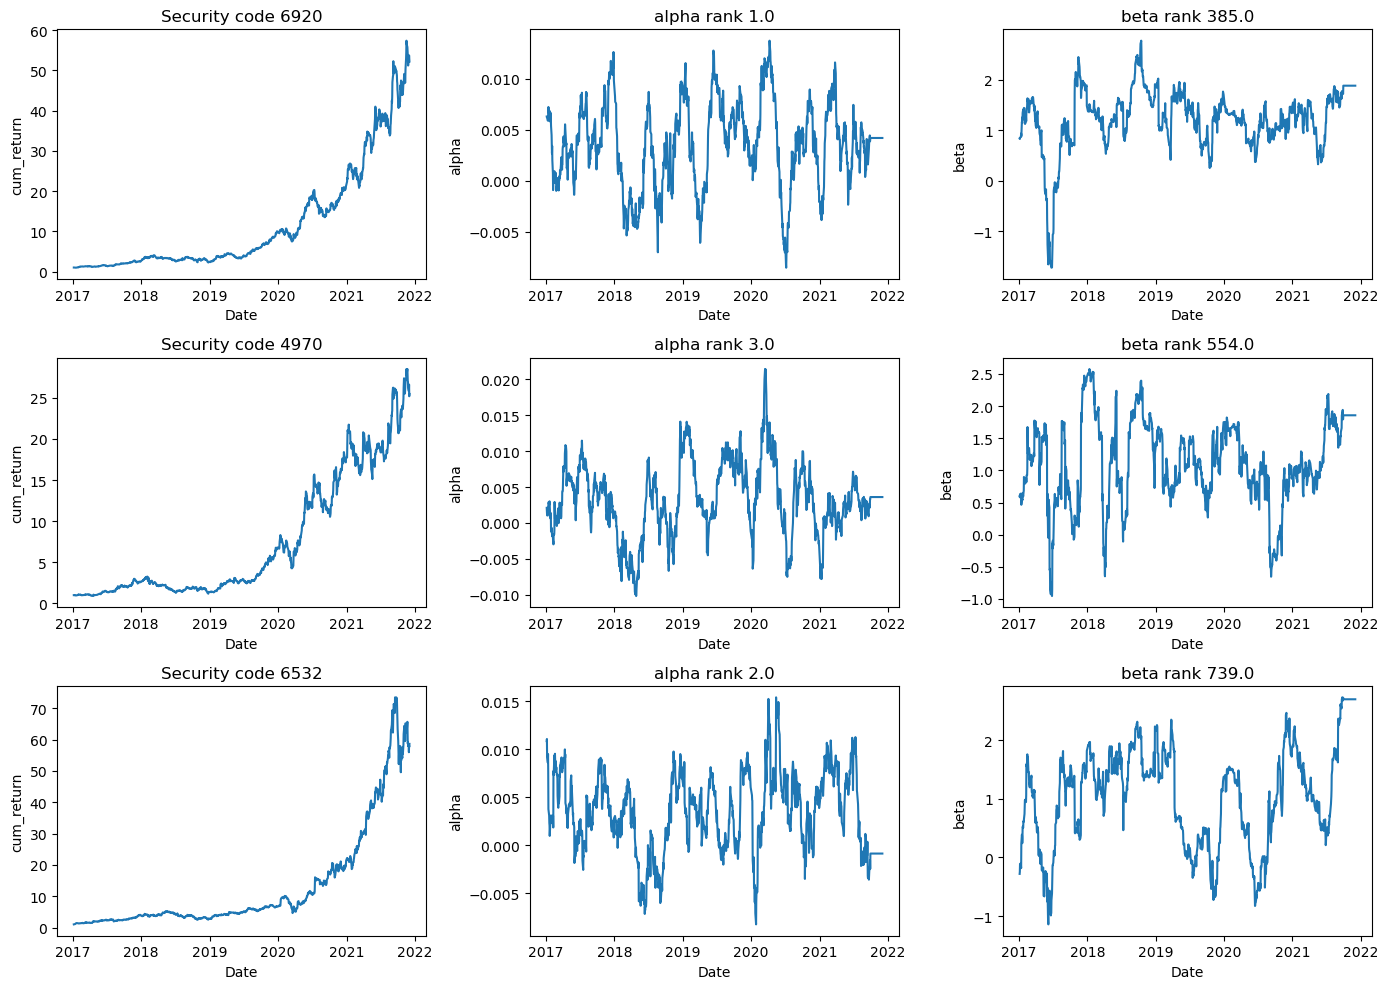

In [20]:
%matplotlib inline
top3_betas = sec_stats[sec_stats.beta_rank<=3].index.to_list()

top3_alphas = sec_stats[sec_stats.alpha_rank<=3].index.to_list()

train.loc[top3_betas]

def plot_target_timeseries(tickers:list, targets:list=None, df:pd.DataFrame =None):
    if df ==None: df =  train
    if targets ==None: targets = ['alpha', 'beta']
    targets = ['cum_return'] + targets

    fig, ax = plt.subplots(len(tickers), len(targets), figsize = (14,10))
    for i, tick in enumerate(tickers):
        ax[i, 0].set_title('Security code {:}'.format(tick))
        ax[i, 1].set_title('alpha rank {:}'.format(sec_stats.loc[tick, 'alpha_rank']))
        ax[i, 2].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))
        for j, targ in enumerate(targets):
            sns.lineplot(df.loc[tick], x= 'Date', y = targ, ax = ax[i, j])
        
    fig.tight_layout()
plot_target_timeseries(top3_betas)
plot_target_timeseries(top3_alphas)

<Axes: xlabel='avg_beta', ylabel='Count'>

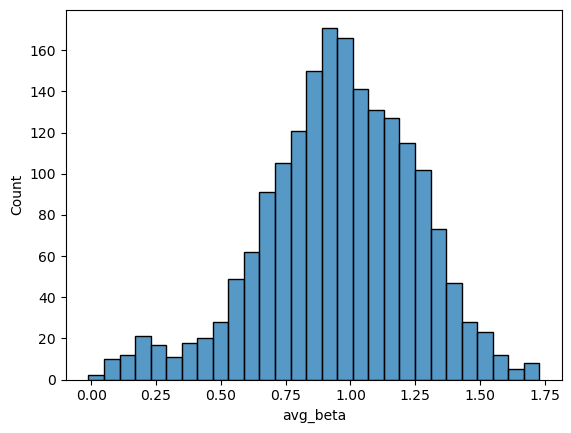

In [21]:
fig, ax = plt.subplots()
sns.histplot(sec_stats, x='avg_beta')

## Options

In [22]:
options_import = pd.read_csv('train_files/options.csv')
options_import['Date'] = pd.to_datetime(options_import['Date'])
options_import['Code']=options_import['OptionsCode'].astype(str).str[:4].astype(int)
# options_import['id'] =options_import['DateCode'].astype(str).str[:13].astype(int)
options_indices = [
    'Code', 'Date',
    'StrikePrice', 
    # 'PutCall', 'ContractMonth',
]
options_import = options_import.set_index(options_indices).sort_index()

/tmp/ipykernel_11585/3009579727.py:1: DtypeWarning: Columns (7,8,9,10) have mixed types. Specify dtype option on import or set low_memory=False.
  options_import = pd.read_csv('train_files/options.csv')


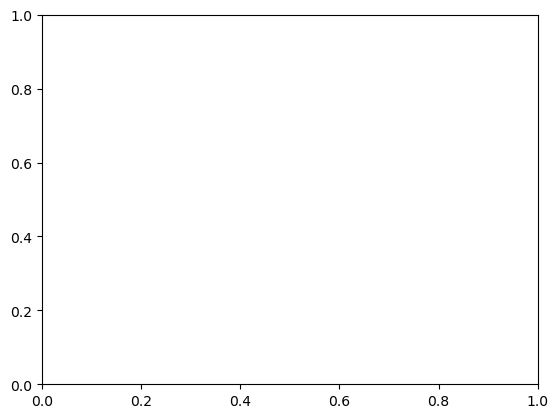

In [23]:
active_set = options_import['WholeDayVolume'] >1000
options = options_import[active_set].copy()
fig, ax = plt.subplots()

# sns.histplot(data =options, x ='WholeDayVolume')
# sns.scatterplot(data = options, x= 'Date', y ='WholeDayVolume')

In [24]:
options.loc[idx[1320, '2017-01-04'], :].T

StrikePrice,16500.0,17000.0,17250.0,17375.0,17500.0,17750.0,17875.0,18000.0,18125.0,18250.0,18375.0,18500.0,18625.0,18750.0,18875.0,19000.0,19125.0,19250.0,19375.0,19500.0
DateCode,20170104_132016518,20170104_132017018,20170104_132017218,20170104_132017318,20170104_132017518,20170104_132017718,20170104_132017818,20170104_132018018,20170104_132018118,20170104_132018218,20170104_132018318,20170104_132018518,20170104_132018618,20170104_132018718,20170104_132018818,20170104_132019018,20170104_132019118,20170104_132019218,20170104_132019318,20170104_132019518
OptionsCode,132016518,132017018,132017218,132017318,132017518,132017718,132017818,132018018,132018118,132018218,132018318,132018518,132018618,132018718,132018818,132019018,132019118,132019218,132019318,132019518
WholeDayOpen,5.0,12.0,15.0,19.0,23.0,33.0,39.0,47.0,55.0,70.0,80.0,95.0,115.0,145.0,170.0,210.0,255.0,315.0,450.0,420.0
WholeDayHigh,8.0,15.0,19.0,24.0,28.0,38.0,46.0,60.0,65.0,80.0,95.0,115.0,135.0,170.0,205.0,250.0,305.0,375.0,450.0,510.0
WholeDayLow,1.0,1.0,2.0,3.0,3.0,5.0,6.0,8.0,11.0,13.0,16.0,20.0,24.0,31.0,41.0,55.0,70.0,90.0,120.0,155.0
WholeDayClose,1.0,2.0,3.0,3.0,4.0,6.0,6.0,8.0,11.0,13.0,16.0,21.0,24.0,31.0,41.0,55.0,70.0,90.0,120.0,155.0
NightSessionOpen,5.0000,12.0000,15.0000,19.0000,23.0000,33.0000,39.0000,47.0000,55.0000,70.0000,80.0000,95.0000,115.0000,145.0000,170.0000,210.0000,255.0000,315.0000,450.0000,420.0000
NightSessionHigh,8.0000,15.0000,19.0000,24.0000,28.0000,38.0000,46.0000,60.0000,65.0000,80.0000,95.0000,115.0000,135.0000,170.0000,205.0000,250.0000,305.0000,375.0000,450.0000,510.0000
NightSessionLow,5.0000,11.0000,15.0000,17.0000,22.0000,32.0000,38.0000,46.0000,55.0000,70.0000,80.0000,90.0000,115.0000,140.0000,170.0000,205.0000,255.0000,315.0000,450.0000,420.0000
NightSessionClose,7.0000,11.0000,17.0000,19.0000,25.0000,35.0000,41.0000,60.0000,65.0000,80.0000,90.0000,115.0000,130.0000,170.0000,205.0000,250.0000,300.0000,375.0000,450.0000,510.0000


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3567694 entries, (1300, Timestamp('2018-07-17 00:00:00'), 18500.0) to (1992, Timestamp('2021-12-03 00:00:00'), 44000.0)
Data columns (total 29 columns):
 #   Column               Dtype  
---  ------               -----  
 0   DateCode             object 
 1   OptionsCode          int64  
 2   WholeDayOpen         float64
 3   WholeDayHigh         float64
 4   WholeDayLow          float64
 5   WholeDayClose        float64
 6   NightSessionOpen     object 
 7   NightSessionHigh     object 
 8   NightSessionLow      object 
 9   NightSessionClose    object 
 10  DaySessionOpen       float64
 11  DaySessionHigh       float64
 12  DaySessionLow        float64
 13  DaySessionClose      float64
 14  TradingVolume        int64  
 15  OpenInterest         int64  
 16  TradingValue         int64  
 17  ContractMonth        int64  
 18  WholeDayVolume       int64  
 19  Putcall              int64  
 20  LastTradingDay       int64  
 21  SpecialQuo

In [25]:
# options_df.groupby('Code', group_keys=False).apply(
#     lambda x: x.groupby('Date').apply(
#         lambda x: x
#     ))

# # options_df.loc[9997].loc['2018-07-17'].sort_values(by = 'OpenInterest', ascending = True).OpenInterest
# # options_df[options_df.WholeDayClose != 0]
# test=options_df['ImpliedVolatility'].groupby('Code').apply(
#     lambda x: x.groupby('Date').apply(
#         # lambda x: x.groupby('StrikePrice').apply(lambda x: x.mean())
#         lambda x: x.median()
#         ))
# test
# options_df['ImpliedVolatility']

## Merge fundamental data to train

In [26]:
# fig, ax = plt.subplots()

# code = 1301
# feat = 'ForecastOperatingProfit'
# df = merged_train.loc[code, feat]

# sns.scatterplot(df)

In [27]:
# train_codes_list = train.index.get_level_values(0).unique().drop(1592)
# test=fund.loc[train_codes_list]

# good_fund_data = fund.loc[fund.index.isin(train.index), fundamental_features]

# train.loc[good_fund_data.index, good_fund_data.columns] = good_fund_data
# display(train)

# Feature engineering

In [28]:

# Feature calculation functions

def pandas_winsor(series, limit = 1-0.99):
    return pd.Series(winsorize(series, limits = limit).data, index =series.index)

def wavelet_smoother(feature, data:pd.DataFrame=None):
    return

# Plotting functions

def feature_timeseries_plot(tickers:list, feature, target, df:pd.DataFrame = None):
    if df == None: df = train

    fig, ax = plt.subplots(2, len(tickers), figsize = (14, 10))

    for i , tick in enumerate(tickers):
        ax[0, i].set_title('Security code {:}'.format(tick))
        ax[1, i].set_title('beta rank {:}'.format(sec_stats.loc[tick, 'beta_rank']))        
        sns.lineplot(df.loc[tick], x= 'Date', y = target, ax = ax[0, i])
        sns.lineplot(df.loc[tick], x= 'Date', y = feature, ax = ax[1, i])
    return

def beta_feature_scatter(feature, spearman = False, df:pd.DataFrame = None,):
    '''
    2 scatter plots of the beta and beta differences vs. the feature
    '''
    fig, ax = plt.subplots(ncols= 2, figsize = (9.2*1.5,5.6))
    feature_scatter(feature, 'beta', spearman, df, fig =fig, ax = ax[0])
    feature_scatter(feature, 'dbeta_sm', df=df,fig =fig, ax = ax[1])

def feature_scatter(feature, target, spearman=False, df:pd.DataFrame=None, fig =None, ax = None):

    if df ==None:
        df = train.loc[train.index.get_level_values(0)!=1592]
    if ax ==None:
        fig, ax = plt.subplots()

    sns.scatterplot(data = df, x = feature, y = target, ax = ax)

    pearson_r = pearsonr(df[feature], df[target])[0]
    print(f'{target} vs {feature} pearson r={pearson_r}')
    ax.set_title('{:} has pearson r of {:.3g}'.format(feature, pearson_r))

    if spearman:
        spearman_r = spearmanr(df[feature], df[target])[0]
        print(f'{target} vs {feature} spearman r={spearman_r}')
    
def feature_heatmap(feat_list:list,targets:list = None, data:pd.DataFrame =None, ):
    '''
    Plots a heat map of the correaltion matrix
    '''
    fig, ax = plt.subplots(figsize = (14, 14))

    if data == None: data = train
    if targets == None: targets = ['beta', 'dbeta_sm']
    cols = feat_list + targets
    sns.heatmap(data[cols].corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')


## Beta factors engineering

* price features
    * standard deviation in returns
    * Bollinger band feature
    * ratio of return to market avg returns
    * average true range 
    * other candle features
    
* Fundamental features
* Implied volatility of atm options
        

## Lagged beta

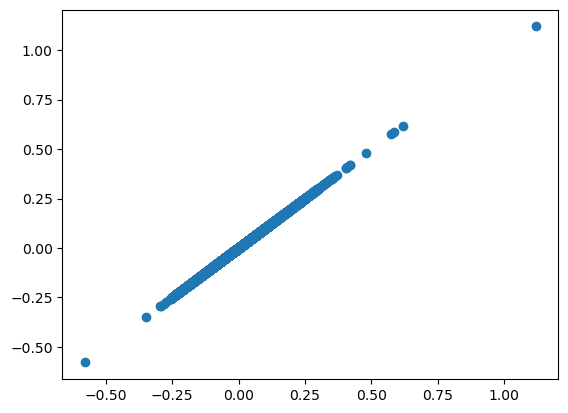

In [29]:
df = train[['AdjClose', 'returns', 'Target']].copy()
df['target_lag2'] = df['Target'].shift(2)
df.dropna(inplace=True)

fig, ax = plt.subplots()

ax.plot(df.returns, df.target_lag2, 'o')


In [30]:
df[np.abs(df['returns']/df['target_lag2']-1)>1E-6].index.get_level_values(1).value_counts()

Series([], Name: Date, dtype: int64)

beta vs beta_hist pearson r=0.42374618306189266


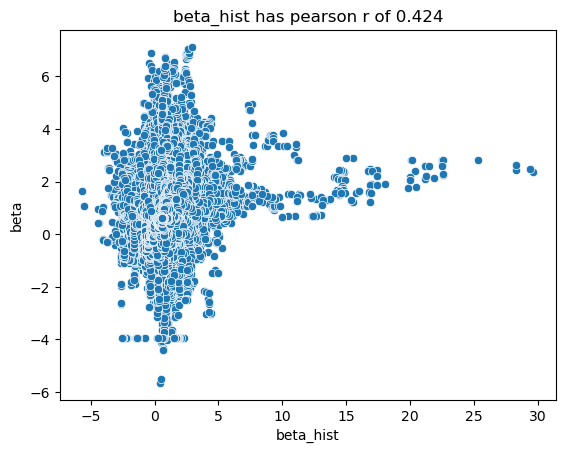

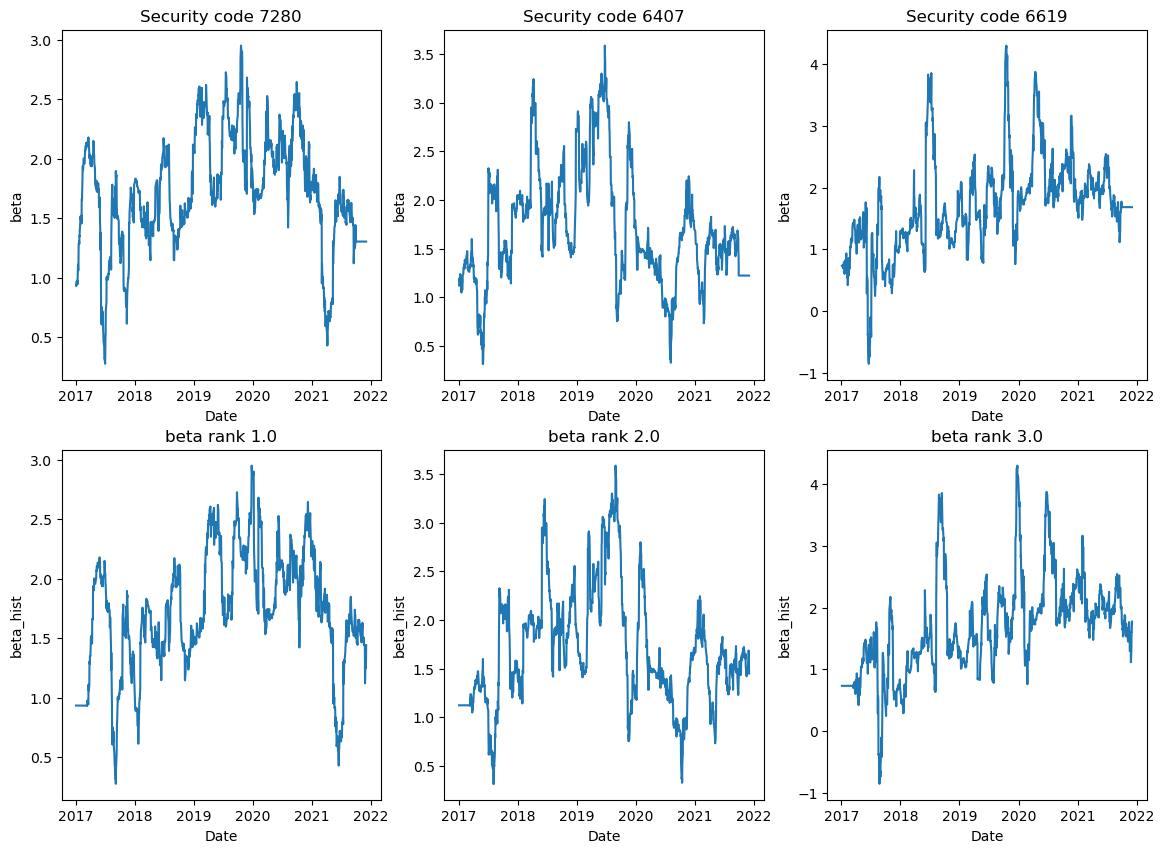

In [31]:
train['covar_hist_i'] = train.groupby('Code', group_keys=False)['returns'].apply(lambda x: x*train.loc[1592, 'returns'])
train['covar_hist'] = train.groupby('Code', group_keys=False)['covar_hist_i'].rolling(45).mean().droplevel(0).bfill()
train['beta_hist'] = train.groupby('Code', group_keys=False)['covar_hist'].apply(lambda x: x/train.loc[1592, 'covar_hist'])


feature_scatter('beta_hist', 'beta')
feature_timeseries_plot(top3_betas, 'beta_hist', target = 'beta')

### Volatility
The standard deviation in returns


10 day period

In [32]:
def calc_volatility(_win, data:pd.DataFrame =None):
    if data ==None: data = train
    col_name = f'sigma_{_win}'
    data[col_name] = data.groupby('Code', group_keys=False)['returns'].apply(
        pandas_winsor).groupby('Code').rolling(_win).std().bfill().droplevel(0)
    return data
    # return data[col_name]

# def wavelet_smoother(feat, data:pd.DataFrame=None):
#     if data == None: data = train
#     col_name = f'{feat}_sm'
#     data[col_name] = data.groupby('Code', group_keys=False).apply(lambda)

In [33]:
vol_windows = [5, 15, 30, 45]
for w in vol_windows: calc_volatility(w)

In [34]:
# train['sigma_10']=train.groupby('Code', group_keys=False)['returns'].apply(
#     pandas_winsor).groupby('Code').rolling(20).std().bfill().droplevel(0)
# train['sigma_10sm']=train.groupby('Code', group_keys=False)['sigma_10'].apply(lambda x: wavelet_smooth(pandas_winsor(x.diff().bfill())))
# beta_feature_imp('sigma_10sm')

beta vs sigma_45 pearson r=0.3089645742175543


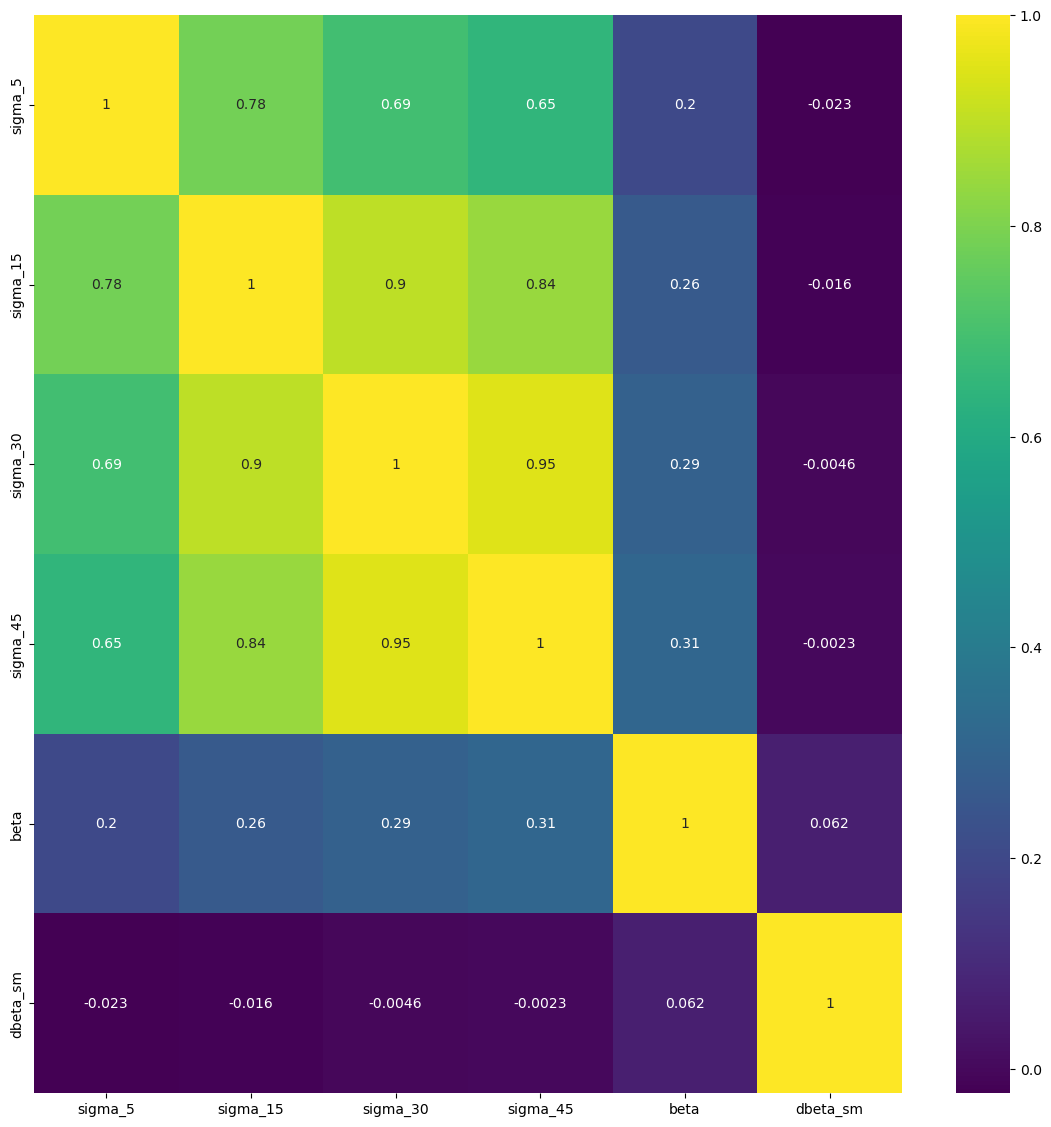

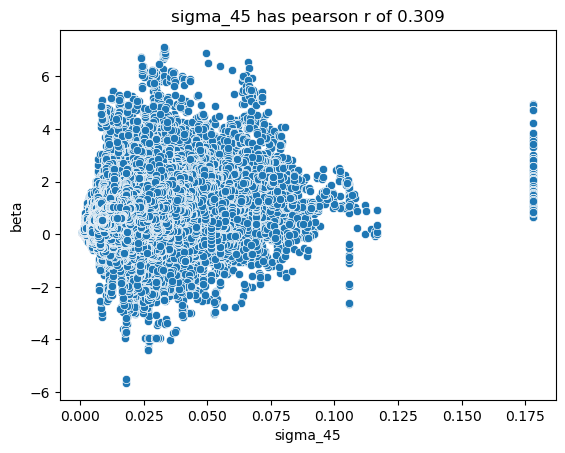

In [35]:
feature_heatmap([f'sigma_{i}' for i in vol_windows])
# beta_feature_scatter('sigma_45')
feature_scatter('sigma_45', 'beta')

## Return to spy return ratio

In [36]:
# def calc_return_ratio


train['sigma_ratio'] = train.groupby('Code', group_keys=False)['sigma_15'].apply(lambda x: x/train.loc[1592, 'sigma_15'])
# beta_feature_imp('sigma_ratio')

## Bollinger band feature

In [37]:
def calc_bbands(periods:list, data:pd.DataFrame = None):
    if data == None: data = train
    for p in periods:
        bbmid_col = f'sma_{p}'
        data[bbmid_col] = data.groupby('Code')['cum_return'].rolling(p).mean().droplevel(0)
        bb_std = data.groupby('Code')['cum_return'].rolling(p).std().droplevel(0)
        data[f'bbhigh_{p}'] = data[bbmid_col] + 2*bb_std
        data[f'bblow_{p}'] = data[bbmid_col] - 2*bb_std
        data[f'bbceil_{p}'] = 1-data['cum_return']/data[f'bbhigh_{p}']
        data[f'bbfloor_{p}'] = 1-data[f'bblow_{p}']/data['cum_return']
        # data[f'bbdiff_{p}'] = data[f'bbceil_{p}']+data[f'bbfloor_{p}']

calc_bbands(vol_windows)
train

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   31400   
     2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   17900   
     2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   19900   
     2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   24200   
     2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0    9300   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-29  20211129_9997   678.0   679.0   665.0   668.0  320800   
     2021-11-30  20211130_9997   670.0   689.0   667.0   667.0  296300   
     2021-12-01  20211201_9997   661.0   688.0   660.0   685.0  339100   
     2021-12-02  20211202_9997   681.0   692.0   680.0   684.0  342900   
     2021-12-03  20211203_9997   690.0   711.0   686.0   696.0  381100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                   Target  ...    sma_30  bbhigh_30  bblow_30  bbceil_30  \
Code Date                  ...                                             
1301 2017-01-04  0.000730  ...       NaN        NaN       NaN        NaN   
     2017-01-05  0.002920  ...       NaN        NaN       NaN        NaN   
     2017-01-06 -0.001092  ...       NaN        NaN       NaN        NaN   
     2017-01-10 -0.005100  ...       NaN        NaN       NaN        NaN   
     2017-01-11 -0.003295  ...       NaN        NaN       NaN        NaN   
...                   ...  ...       ...        ...       ...        ...   
9997 2021-11-29  0.026987  ...  0.949491   1.063840  0.835141   0.220418   
     2021-11-30 -0.001460  ...  0.942621   1.060616  0.824625   0.219219   
     2021-12-01  0.017544  ...  0.936454   1.053709  0.819200   0.192892   
     2021-12-02  0.014368  ...  0.930454   1.046479  0.814428   0.188503   
     2021-12-03  0.018414  ...  0.925363   1.039086  0.811641   0.168390   

                 bbfloor_30    sma_45  bbhigh_45  bblow_45  bbceil_45  \
Code Date                                                               
1301 2017-01-04         NaN       NaN        NaN       NaN        NaN   
     2017-01-05         NaN       NaN        NaN       NaN        NaN   
     2017-01-06         NaN       NaN        NaN       NaN        NaN   
     2017-01-10         NaN       NaN        NaN       NaN        NaN   
     2017-01-11         NaN       NaN        NaN       NaN        NaN   
...                     ...       ...        ...       ...        ...   
9997 2021-11-29   -0.006982  0.979219   1.106390  0.852047   0.250399   
     2021-11-30    0.004207  0.974059   1.106506  0.841612   0.251600   
     2021-12-01    0.036753  0.969341   1.103970  0.834713   0.229637   
     2021-12-02    0.040964  0.965010   1.102310  0.827710   0.229604   
     2021-12-03    0.060725  0.960982   1.099268  0.822695   0.213919   

                 bbfloor_45  
Code Date                    
1301 2017-01-04         NaN  
     2017-01-05         NaN  
     2017-01-06         NaN  
     2017-01-10         NaN  
     2

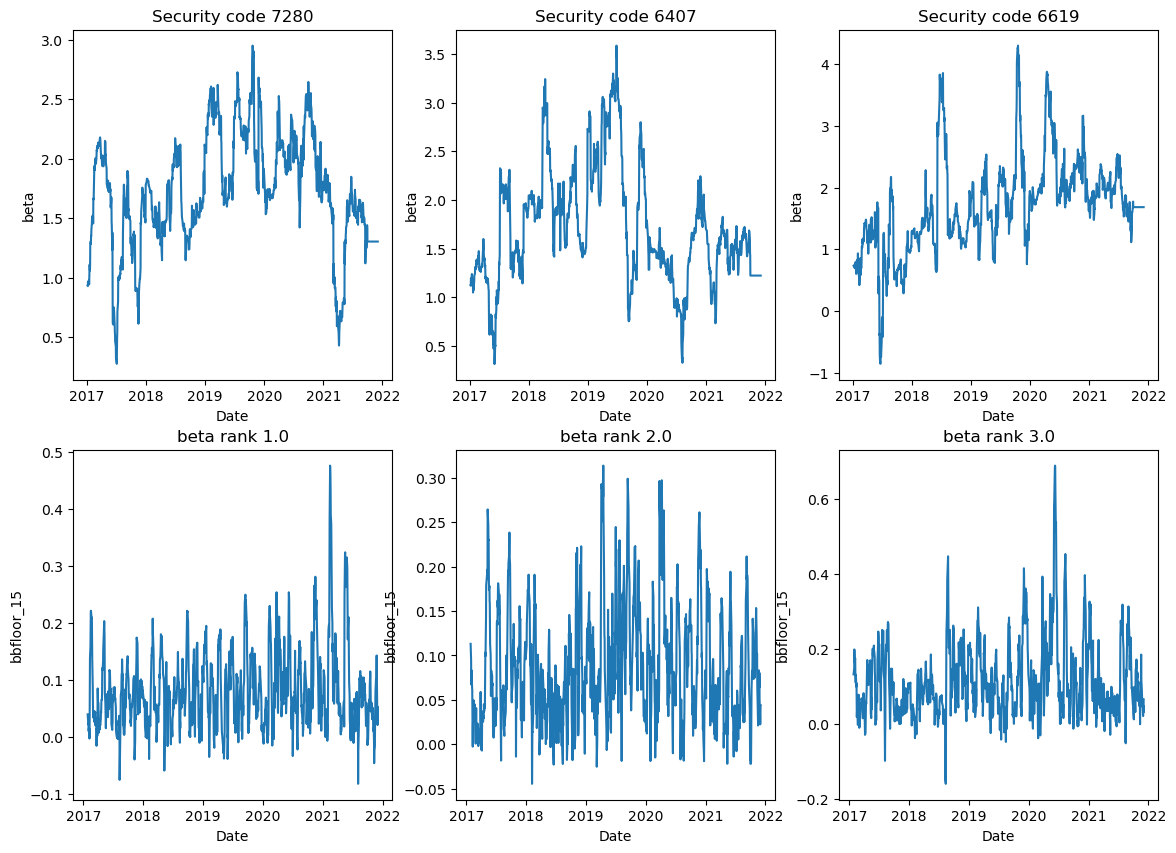

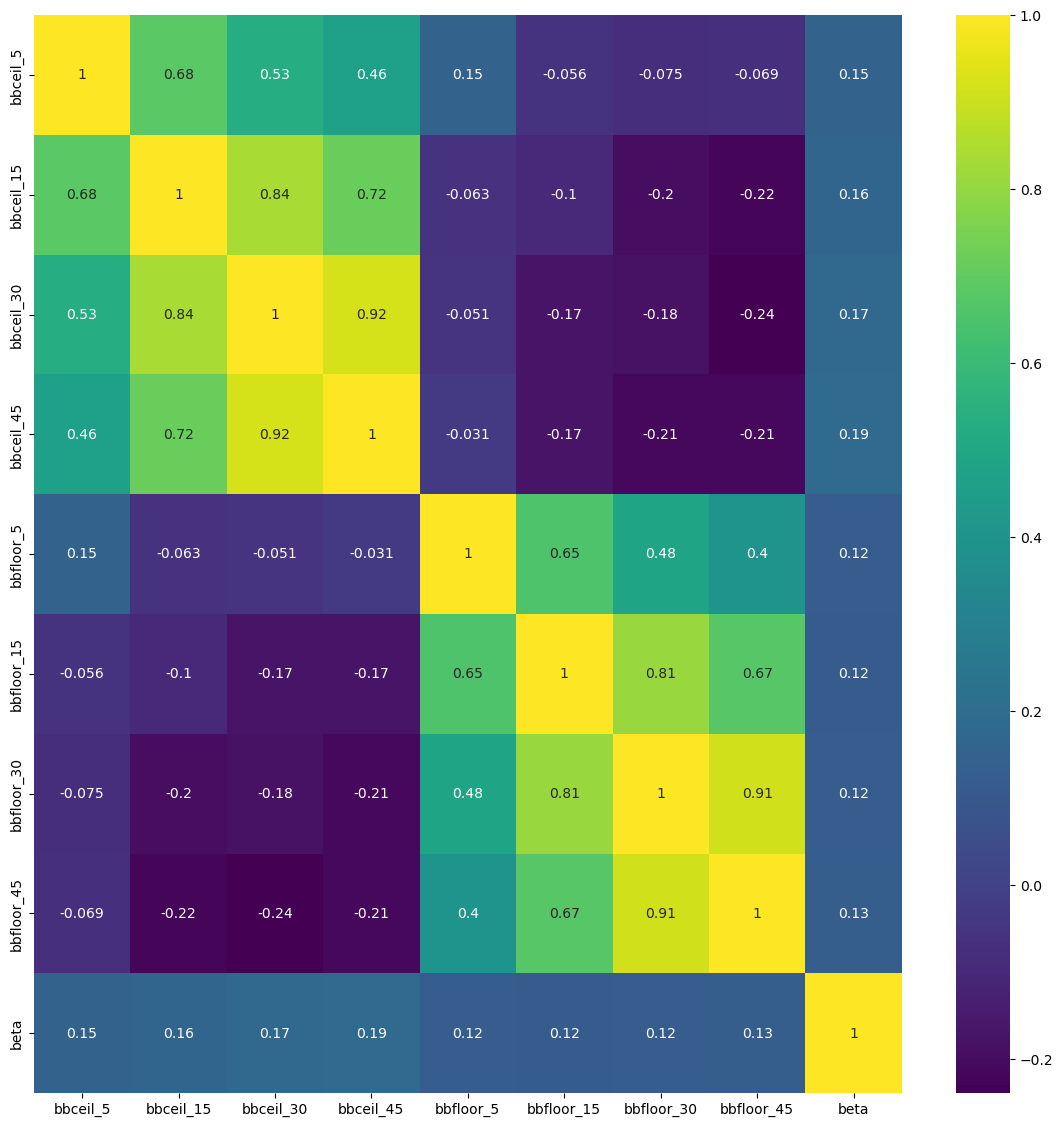

In [38]:
feature_timeseries_plot(top3_betas, 'bbfloor_15', 'beta')

bb_feats = [f'bbceil_{i}' for i in vol_windows]+[f'bbfloor_{i}' for i in vol_windows]#+[f'bbdiff_{i}' for i in vol_windows]
feature_heatmap(bb_feats, targets = ['beta'])

## ATR features

In [39]:
train['ATR_1'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_2'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['High'] - x['Open'])*x['AdjustmentFactor'].cumprod()).droplevel(0)
train['ATR_3'] =train.groupby('Code').apply(lambda x: (1/x['Close'])*(x['Open'] - x['Low'])*x['AdjustmentFactor'].cumprod()).droplevel(0)

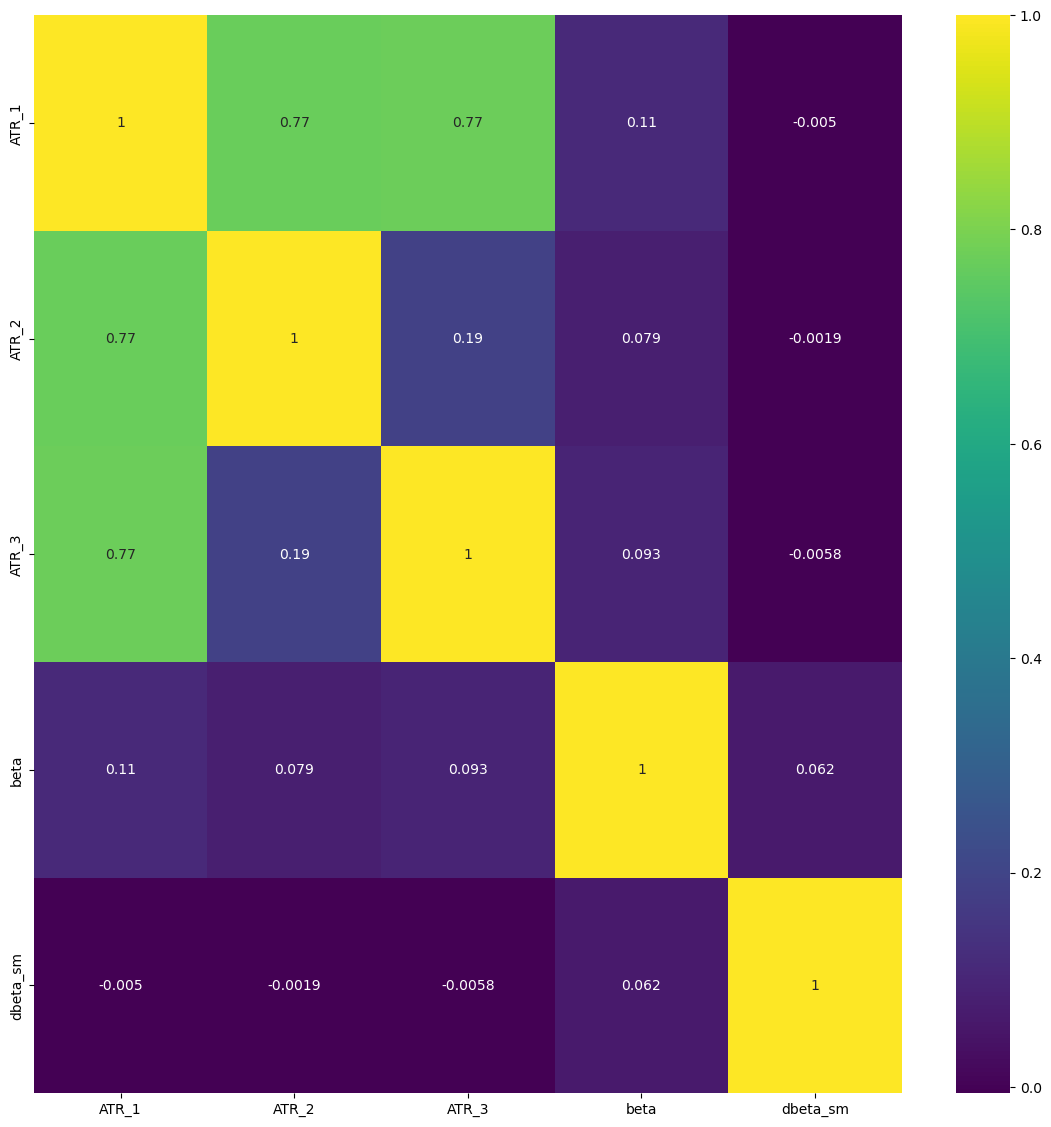

In [40]:
feature_heatmap(['ATR_1', 'ATR_2', 'ATR_3'])

In [41]:
train

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2017-01-04  20170104_1301  2734.0  2755.0  2730.0  2742.0   31400   
     2017-01-05  20170105_1301  2743.0  2747.0  2735.0  2738.0   17900   
     2017-01-06  20170106_1301  2734.0  2744.0  2720.0  2740.0   19900   
     2017-01-10  20170110_1301  2745.0  2754.0  2735.0  2748.0   24200   
     2017-01-11  20170111_1301  2748.0  2752.0  2737.0  2745.0    9300   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-29  20211129_9997   678.0   679.0   665.0   668.0  320800   
     2021-11-30  20211130_9997   670.0   689.0   667.0   667.0  296300   
     2021-12-01  20211201_9997   661.0   688.0   660.0   685.0  339100   
     2021-12-02  20211202_9997   681.0   692.0   680.0   684.0  342900   
     2021-12-03  20211203_9997   690.0   711.0   686.0   696.0  381100   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2017-01-04               1.0               NaN            False   
     2017-01-05               1.0               NaN            False   
     2017-01-06               1.0               NaN            False   
     2017-01-10               1.0               NaN            False   
     2017-01-11               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-29               1.0               NaN            False   
     2021-11-30               1.0               NaN            False   
     2021-12-01               1.0               NaN            False   
     2021-12-02               1.0               NaN            False   
     2021-12-03               1.0               NaN            False   

                   Target  ...  bbceil_30  bbfloor_30    sma_45  bbhigh_45  \
Code Date                  ...                                               
1301 2017-01-04  0.000730  ...        NaN         NaN       NaN        NaN   
     2017-01-05  0.002920  ...        NaN         NaN       NaN        NaN   
     2017-01-06 -0.001092  ...        NaN         NaN       NaN        NaN   
     2017-01-10 -0.005100  ...        NaN         NaN       NaN        NaN   
     2017-01-11 -0.003295  ...        NaN         NaN       NaN        NaN   
...                   ...  ...        ...         ...       ...        ...   
9997 2021-11-29  0.026987  ...   0.220418   -0.006982  0.979219   1.106390   
     2021-11-30 -0.001460  ...   0.219219    0.004207  0.974059   1.106506   
     2021-12-01  0.017544  ...   0.192892    0.036753  0.969341   1.103970   
     2021-12-02  0.014368  ...   0.188503    0.040964  0.965010   1.102310   
     2021-12-03  0.018414  ...   0.168390    0.060725  0.960982   1.099268   

                 bblow_45  bbceil_45  bbfloor_45     ATR_1     ATR_2     ATR_3  
Code Date                                                                       
1301 2017-01-04       NaN        NaN         NaN  0.009117  0.007659  0.001459  
     2017-01-05       NaN        NaN         NaN  0.004383  0.001461  0.002922  
     2017-01-06       NaN        NaN         NaN  0.008759  0.003650  0.005109  
     2017-01-10       NaN        NaN         NaN  0.006914  0.003275  0.003639  
     2017-01-11       NaN        NaN         NaN  0.005464  0.001457  0.004007  
...                   ...        ...         ...       ...       ...       ...  
9997 2021-11-29  0.852047   0.250399   -0.027367  0.020958  0.001497  0.019461  
     2021-11-30  0.841612   0.251600   -0.016306  0.032984  0.028486  0.004498  
     2021-12-01  0.834713   0.229637    0.018512  0.040876  0.039416  0.001460  
     2021-12-02  0.827710   0.229604    0.025324  0.017544  0.016082  0.001462  
     2021-12-03  0.822695   0.213919    0.047932  0.035920  0.030172  0.005747  

[2241066 rows x 52 columns]

/tmp/ipykernel_15497/3948464539.py:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  train['week'] = train.index.get_level_values(1).weekofyear
/tmp/ipykernel_15497/187048690.py:57: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data[cols].corr(), ax = ax, cmap = 'viridis',annot=True, fmt = '.2g')


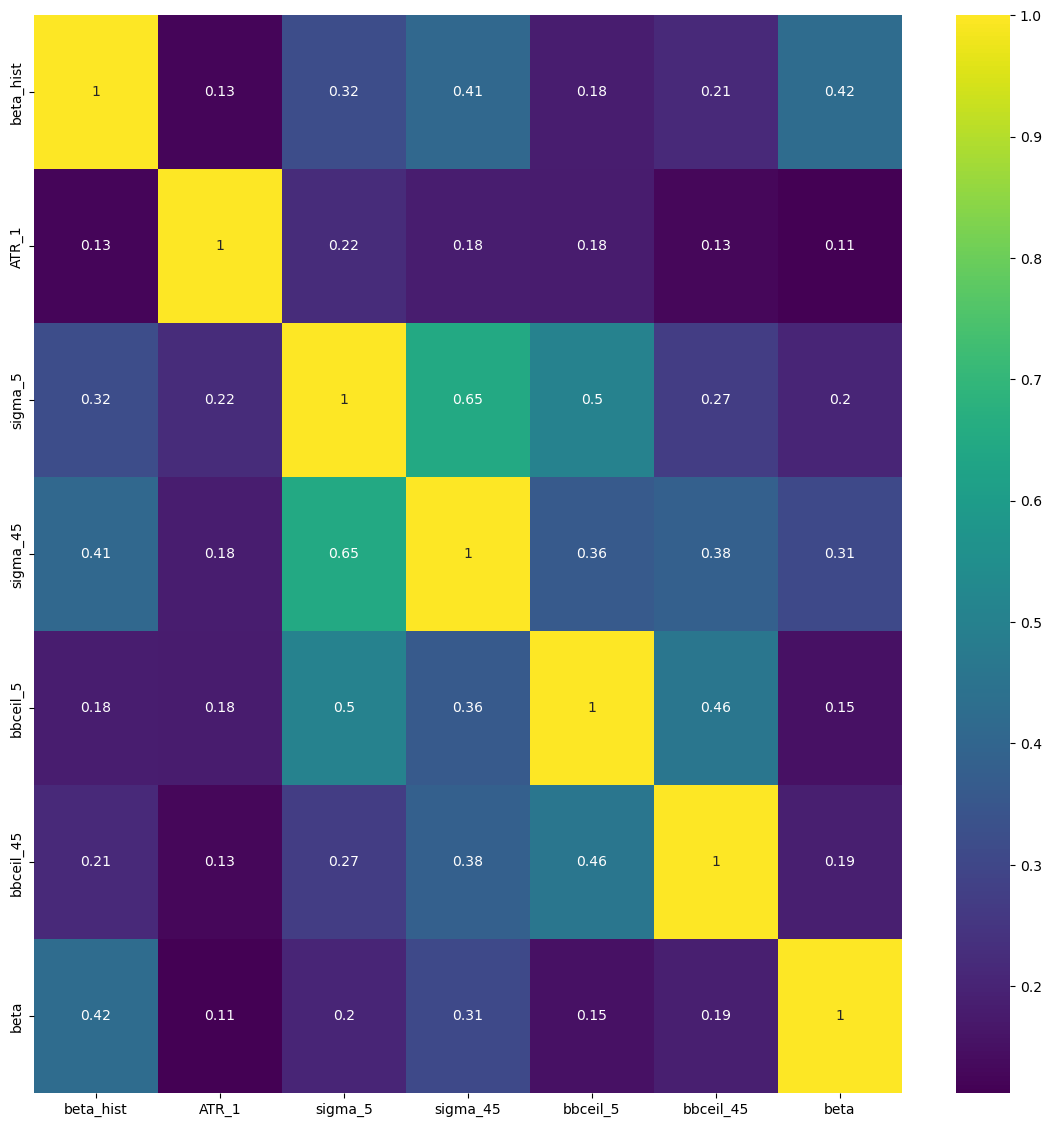

In [42]:
train['ticker'] = train.index.get_level_values(0)
train['month'] = train.index.get_level_values(1).month 
train['week'] = train.index.get_level_values(1).weekofyear
atr_feats = [f'ATR_{i+1}' for i in range(3)]
vol_feats = [f'sigma_{i}' for i in vol_windows]

cat_feats = ['ticker', 'month', 'week']
train[cat_feats] = train[cat_feats].astype('category')

custom_picked_feats = [
    'beta_hist', 
    'ATR_1', 
    'sigma_5', 
    'sigma_45',
    'bbceil_5', 
    'bbceil_45', 
    ]


# beta_feature_list = atr_feats+vol_feats+bb_feats +cat_feats
beta_feature_list =custom_picked_feats+cat_feats

feature_heatmap(beta_feature_list, ['beta'])


holdout = 2021


# train['beta'] = np.log1p(train['beta'])
train = train.drop(index = 1592, axis = 0).loc[idx[:, '2017-02-14':'2021-11-15'],:]
X = train.loc[idx[:, '2017':str(holdout-1)], beta_feature_list].copy()
y = train.loc[idx[:, '2017': str(holdout-1)], 'beta'].copy()

X_holdout = train.loc[idx[:, str(holdout)], beta_feature_list].copy()
y_holdout = train.loc[idx[:, str(holdout)], 'beta'].copy()



# Cross validation scheme

I'll use a custom cross validator from Stefan Jansen's github that accepts a multindex dataframe has a class argument.  
* Leave the most recent year out as a holdout set for evaluation
* I'll make my train period 1 year to capture any seasonal effects, and test on half a year
* Using the time seires walk forward approach, data on January 2017 - December 2021 should yield about **6** training and validation sets with **1** holdout test set on the full year  of 2021

In [43]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(1).unique()
        days = sorted(unique_dates, reverse=True)
        # days = unique_dates
        # days = sorted(unique_dates, reverse=False)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()['Date']
        # self.dates = dates
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates > days[train_start])
                              & (dates <= days[train_end])].index
            test_idx = dates[(dates > days[test_start])
                             & (dates <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits



In [44]:
train.loc[idx[:, '2021'], :]

RowId    Open    High     Low   Close  Volume  \
Code Date                                                                
1301 2021-01-04  20210104_1301  2951.0  2951.0  2913.0  2950.0    9700   
     2021-01-05  20210105_1301  2950.0  2959.0  2935.0  2956.0   11000   
     2021-01-06  20210106_1301  2958.0  2990.0  2955.0  2990.0   23000   
     2021-01-07  20210107_1301  2990.0  2995.0  2975.0  2989.0   20400   
     2021-01-08  20210108_1301  2988.0  3020.0  2971.0  2999.0   29500   
...                        ...     ...     ...     ...     ...     ...   
9997 2021-11-09  20211109_9997   767.0   772.0   763.0   763.0  233500   
     2021-11-10  20211110_9997   762.0   769.0   759.0   765.0  120800   
     2021-11-11  20211111_9997   764.0   765.0   752.0   752.0  187900   
     2021-11-12  20211112_9997   751.0   762.0   751.0   756.0  173600   
     2021-11-15  20211115_9997   757.0   762.0   744.0   747.0  261600   

                 AdjustmentFactor  ExpectedDividend  SupervisionFlag  \
Code Date                                                              
1301 2021-01-04               1.0               NaN            False   
     2021-01-05               1.0               NaN            False   
     2021-01-06               1.0               NaN            False   
     2021-01-07               1.0               NaN            False   
     2021-01-08               1.0               NaN            False   
...                           ...               ...              ...   
9997 2021-11-09               1.0               NaN            False   
     2021-11-10               1.0               NaN            False   
     2021-11-11               1.0               NaN            False   
     2021-11-12               1.0               NaN            False   
     2021-11-15               1.0               NaN            False   

                   Target  ...  bbhigh_45  bblow_45  bbceil_45  bbfloor_45  \
Code Date                  ...                                               
1301 2021-01-04  0.011502  ...   1.055262  0.957534   0.007969    0.085321   
     2021-01-05 -0.000334  ...   1.057263  0.959113   0.007833    0.085673   
     2021-01-06  0.003346  ...   1.060421  0.959929  -0.000590    0.095300   
     2021-01-07  0.043681  ...   1.063069  0.961351   0.002236    0.093657   
     2021-01-08 -0.006390  ...   1.066342  0.961736   0.001971    0.096317   
...                   ...  ...        ...       ...        ...         ...   
9997 2021-11-09 -0.016993  ...   1.119151  0.944128   0.153557    0.003345   
     2021-11-10  0.005319  ...   1.118979  0.938947   0.151208    0.011406   
     2021-11-11 -0.011905  ...   1.119147  0.932543   0.165758    0.001175   
     2021-11-12 -0.021419  ...   1.117741  0.927494   0.160265    0.011839   
     2021-11-15  0.004104  ...   1.116913  0.921590   0.169647    0.006300   

                    ATR_1     ATR_2     ATR_3  ticker  month  week  
Code Date                                                           
1301 2021-01-04  0.012881  0.000000  0.012881    1301      1     1  
     2021-01-05  0.008119  0.003045  0.005074    1301      1     1  
     2021-01-06  0.011706  0.010702  0.001003    1301      1     1  
     2021-01-07  0.006691  0.001673  0.005018    1301      1     1  
     2021-01-08  0.016339  0.010670  0.005669    1301      1     1  
...                   ...       ...       ...     ...    ...   ...  
9997 2021-11-09  0.011796  0.006553  0.005242    9997     11    45  
     2021-11-10  0.013072  0.009150  0.003922    9997     11    45  
     2021-11-11  0.017287  0.001330  0.015957    9997     11    45  
     2021-11-12  0.014550  0.014550  0.000000    9997     11    45  
     2021-11-15  0.024096  0.006693  0.017403    9997     11    46  

[397245 rows x 55 columns]

In [45]:
cv = MultipleTimeSeriesCV(n_splits=6, train_period_length=220-45, test_period_length=110, lookahead=45)

i = 0
for train_idx, test_idx in cv.split(X=X):
    X_train = X.iloc[train_idx]
    train_dates = X_train.index.get_level_values(1)
    X_test = X.iloc[test_idx]
    test_dates = X_test.index.get_level_values(1)
    df = pd.concat((X_train.reset_index(), X_test.reset_index()), axis = 0)
    n = len(df)
    # assert n== len(df.drop_duplicates())
    print(X_train.groupby(level=0).size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          X_test.groupby(level=0).size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break



219 2019-06-20 2020-05-18 110 2020-07-20 2020-12-30
219 2019-01-04 2019-11-28 110 2020-02-06 2020-07-17
219 2018-07-23 2019-06-18 110 2019-08-22 2020-02-05
219 2018-02-09 2018-12-27 110 2019-03-08 2019-08-21
219 2017-08-29 2018-07-19 110 2018-09-21 2019-03-07
219 2017-03-21 2018-02-07 110 2018-04-13 2018-09-20


In [46]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr, spearmanr

In [62]:
model_names = [f'model_{i}' for i in range(cv.n_splits)]
metrics_df = pd.DataFrame(
    index = ['rmse', 'mae', 'pearson_r', 'spearman_r']
    , columns = model_names
)
train_predictions = pd.DataFrame(index = X.index.to_numpy(), columns = model_names)

xgb_models = {}
xgb_cv_results = {}

xgb_params = {
    'enable_categorical': True,
    'n_estimators': 3000,
    'early_stopping_rounds': 100,
    'eta': 0.005,
    'objective':'reg:squarederror',
    'verbosity':0,
    'eval_metric': ['rmse', 'mae'],
    'max_depth': 6,#6,
    # 'gamma': 0.5,
    'min_child_weight': 1,
    'booster': 'gbtree',
    'tree_method': 'hist',
    'sampling_method': 'gradient_based',
    'subsample':0.1,
    'colsample_bytree':0.5,
    'colsample_bylevel': 1,
    'alpha': 200,#10,
    'lambda': 300,#30,
    'device': 'cuda',
}
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    model_no = f'model_{i}'

    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = xgb.XGBRegressor(**xgb_params)
    eval_set = (X_test, y_test)
    eval_results = []
    model.fit(
        X = X_train, y= y_train,
        eval_set = [(X_train, y_train), (X_test, y_test)]
    )

    xgb_models[model_no] = model
    xgb_cv_results[model_no] = model.evals_result()

    ypred_test = model.predict(X_test)

    metrics_df.loc['rmse', model_no] = mean_squared_error(y_test, ypred_test, squared=False)
    metrics_df.loc['mae', model_no] = mean_absolute_error(y_test, ypred_test)
    metrics_df.loc['pearson_r', model_no] = pearsonr(y_test, ypred_test)[0]
    metrics_df.loc['spearman_r', model_no] = spearmanr(y_test, ypred_test)[0]
    train_predictions.loc[:, model_no] = model.predict(X)


[0]	validation_0-rmse:0.51735	validation_0-mae:0.39498	validation_1-rmse:0.50661	validation_1-mae:0.39408
[1]	validation_0-rmse:0.51665	validation_0-mae:0.39440	validation_1-rmse:0.50600	validation_1-mae:0.39357
[2]	validation_0-rmse:0.51644	validation_0-mae:0.39424	validation_1-rmse:0.50585	validation_1-mae:0.39347
[3]	validation_0-rmse:0.51606	validation_0-mae:0.39390	validation_1-rmse:0.50569	validation_1-mae:0.39334
[4]	validation_0-rmse:0.51551	validation_0-mae:0.39342	validation_1-rmse:0.50517	validation_1-mae:0.39291
[5]	validation_0-rmse:0.51493	validation_0-mae:0.39293	validation_1-rmse:0.50463	validation_1-mae:0.39247
[6]	validation_0-rmse:0.51422	validation_0-mae:0.39233	validation_1-rmse:0.50406	validation_1-mae:0.39199
[7]	validation_0-rmse:0.51390	validation_0-mae:0.39206	validation_1-rmse:0.50396	validation_1-mae:0.39192
[8]	validation_0-rmse:0.51320	validation_0-mae:0.39148	validation_1-rmse:0.50337	validation_1-mae:0.39144
[9]	validation_0-rmse:0.51252	validation_0-mae

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


[4]	validation_0-rmse:0.55523	validation_0-mae:0.43143	validation_1-rmse:0.51780	validation_1-mae:0.40176
[5]	validation_0-rmse:0.55441	validation_0-mae:0.43074	validation_1-rmse:0.51712	validation_1-mae:0.40121
[6]	validation_0-rmse:0.55354	validation_0-mae:0.43001	validation_1-rmse:0.51647	validation_1-mae:0.40068
[7]	validation_0-rmse:0.55322	validation_0-mae:0.42974	validation_1-rmse:0.51634	validation_1-mae:0.40058
[8]	validation_0-rmse:0.55240	validation_0-mae:0.42903	validation_1-rmse:0.51569	validation_1-mae:0.40006
[9]	validation_0-rmse:0.55154	validation_0-mae:0.42831	validation_1-rmse:0.51504	validation_1-mae:0.39953
[10]	validation_0-rmse:0.55073	validation_0-mae:0.42760	validation_1-rmse:0.51446	validation_1-mae:0.39905
[11]	validation_0-rmse:0.55048	validation_0-mae:0.42740	validation_1-rmse:0.51432	validation_1-mae:0.39895
[12]	validation_0-rmse:0.55008	validation_0-mae:0.42713	validation_1-rmse:0.51410	validation_1-mae:0.39878
[13]	validation_0-rmse:0.54967	validation_0

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


[1]	validation_0-rmse:0.50126	validation_0-mae:0.38781	validation_1-rmse:0.52178	validation_1-mae:0.39234
[2]	validation_0-rmse:0.50089	validation_0-mae:0.38753	validation_1-rmse:0.52155	validation_1-mae:0.39214
[3]	validation_0-rmse:0.50023	validation_0-mae:0.38696	validation_1-rmse:0.52119	validation_1-mae:0.39177
[4]	validation_0-rmse:0.49948	validation_0-mae:0.38638	validation_1-rmse:0.52060	validation_1-mae:0.39123
[5]	validation_0-rmse:0.49873	validation_0-mae:0.38579	validation_1-rmse:0.51998	validation_1-mae:0.39068
[6]	validation_0-rmse:0.49787	validation_0-mae:0.38510	validation_1-rmse:0.51946	validation_1-mae:0.39021
[7]	validation_0-rmse:0.49751	validation_0-mae:0.38481	validation_1-rmse:0.51927	validation_1-mae:0.39005
[8]	validation_0-rmse:0.49679	validation_0-mae:0.38421	validation_1-rmse:0.51869	validation_1-mae:0.38952
[9]	validation_0-rmse:0.49604	validation_0-mae:0.38361	validation_1-rmse:0.51813	validation_1-mae:0.38902
[10]	validation_0-rmse:0.49525	validation_0-ma

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


[4]	validation_0-rmse:0.50884	validation_0-mae:0.38909	validation_1-rmse:0.53282	validation_1-mae:0.41790
[5]	validation_0-rmse:0.50832	validation_0-mae:0.38863	validation_1-rmse:0.53218	validation_1-mae:0.41736
[6]	validation_0-rmse:0.50762	validation_0-mae:0.38802	validation_1-rmse:0.53153	validation_1-mae:0.41680
[7]	validation_0-rmse:0.50727	validation_0-mae:0.38773	validation_1-rmse:0.53130	validation_1-mae:0.41661
[8]	validation_0-rmse:0.50669	validation_0-mae:0.38722	validation_1-rmse:0.53068	validation_1-mae:0.41609
[9]	validation_0-rmse:0.50613	validation_0-mae:0.38673	validation_1-rmse:0.53005	validation_1-mae:0.41556
[10]	validation_0-rmse:0.50543	validation_0-mae:0.38611	validation_1-rmse:0.52945	validation_1-mae:0.41505
[11]	validation_0-rmse:0.50518	validation_0-mae:0.38591	validation_1-rmse:0.52927	validation_1-mae:0.41491
[12]	validation_0-rmse:0.50491	validation_0-mae:0.38569	validation_1-rmse:0.52909	validation_1-mae:0.41476
[13]	validation_0-rmse:0.50461	validation_0

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


[5]	validation_0-rmse:0.52873	validation_0-mae:0.40467	validation_1-rmse:0.50659	validation_1-mae:0.38955
[6]	validation_0-rmse:0.52813	validation_0-mae:0.40414	validation_1-rmse:0.50615	validation_1-mae:0.38919
[7]	validation_0-rmse:0.52780	validation_0-mae:0.40386	validation_1-rmse:0.50597	validation_1-mae:0.38905
[8]	validation_0-rmse:0.52731	validation_0-mae:0.40341	validation_1-rmse:0.50560	validation_1-mae:0.38874
[9]	validation_0-rmse:0.52684	validation_0-mae:0.40299	validation_1-rmse:0.50523	validation_1-mae:0.38843
[10]	validation_0-rmse:0.52626	validation_0-mae:0.40246	validation_1-rmse:0.50483	validation_1-mae:0.38810
[11]	validation_0-rmse:0.52598	validation_0-mae:0.40222	validation_1-rmse:0.50472	validation_1-mae:0.38802
[12]	validation_0-rmse:0.52571	validation_0-mae:0.40199	validation_1-rmse:0.50458	validation_1-mae:0.38793
[13]	validation_0-rmse:0.52546	validation_0-mae:0.40178	validation_1-rmse:0.50447	validation_1-mae:0.38784
[14]	validation_0-rmse:0.52496	validation_

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


[2]	validation_0-rmse:0.55740	validation_0-mae:0.41768	validation_1-rmse:0.55753	validation_1-mae:0.42116
[3]	validation_0-rmse:0.55694	validation_0-mae:0.41728	validation_1-rmse:0.55739	validation_1-mae:0.42101
[4]	validation_0-rmse:0.55669	validation_0-mae:0.41706	validation_1-rmse:0.55707	validation_1-mae:0.42071
[5]	validation_0-rmse:0.55645	validation_0-mae:0.41683	validation_1-rmse:0.55674	validation_1-mae:0.42042
[6]	validation_0-rmse:0.55589	validation_0-mae:0.41633	validation_1-rmse:0.55645	validation_1-mae:0.42012
[7]	validation_0-rmse:0.55558	validation_0-mae:0.41606	validation_1-rmse:0.55637	validation_1-mae:0.42005
[8]	validation_0-rmse:0.55513	validation_0-mae:0.41564	validation_1-rmse:0.55612	validation_1-mae:0.41980
[9]	validation_0-rmse:0.55469	validation_0-mae:0.41523	validation_1-rmse:0.55585	validation_1-mae:0.41954
[10]	validation_0-rmse:0.55415	validation_0-mae:0.41473	validation_1-rmse:0.55557	validation_1-mae:0.41925
[11]	validation_0-rmse:0.55386	validation_0-m

/tmp/ipykernel_15497/2464879330.py:55: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_predictions.loc[:, model_no] = model.predict(X)


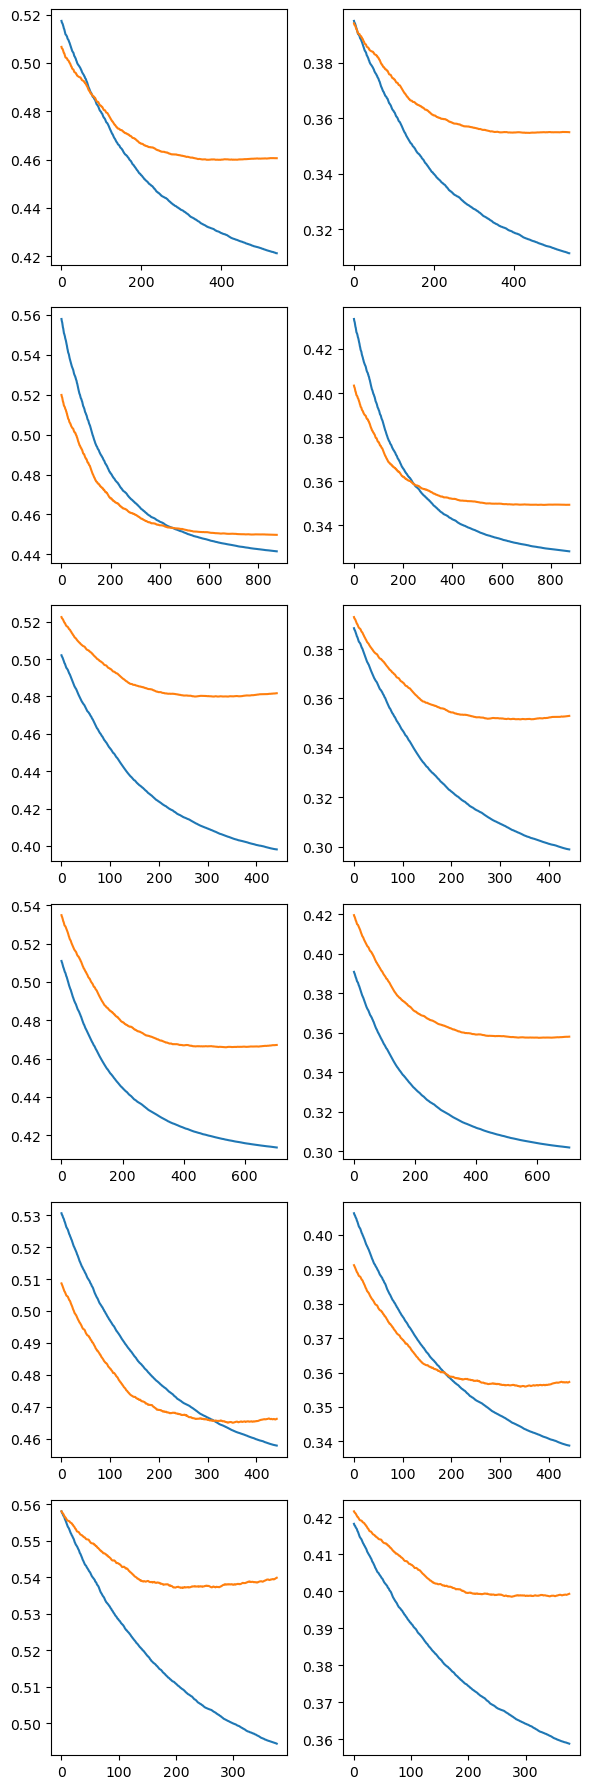

In [63]:
fig, ax = plt.subplots(cv.n_splits, 2, figsize = (3*2, 18), tight_layout = True)
for i, fold_no in enumerate(xgb_cv_results.keys()):

    fold = xgb_cv_results[fold_no]

    for j, set_no in enumerate(fold.keys()):
        set = fold[set_no]
        for k, metric in enumerate(set.keys()):
            data = np.array((set[metric]))
            ax[i, k].plot(data)
            

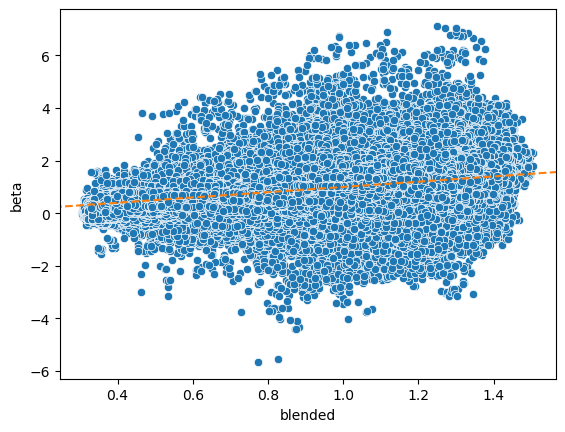

In [64]:
metrics_df.loc['pearson_weight'] = metrics_df.loc['pearson_r']/metrics_df.loc['pearson_r'].sum()
train_predictions['blended'] = (train_predictions*metrics_df.loc['pearson_weight']).sum(axis = 1)

fig, ax = plt.subplots()

sns.scatterplot(x=train_predictions['blended'],y= y)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y.min(), y.max()], '--',color = 'tab:orange')

In [65]:
pearsonr(train_predictions['blended'], y.dropna())

PearsonRResult(statistic=0.4921791175216332, pvalue=0.0)

,model_0,model_1,model_2,model_3,model_4,model_5
rmse,0.370007,0.357537,0.359124,0.363261,0.39006,0.398734
mae,0.278749,0.266533,0.27089,0.272939,0.297321,0.30413
pearson_r,0.511019,0.558027,0.56814,0.536624,0.425973,0.378309
spearman_r,0.510458,0.553416,0.563573,0.534653,0.421059,0.35901
pearson_weight,0.171593,0.187377,0.190773,0.180191,0.143036,0.127031


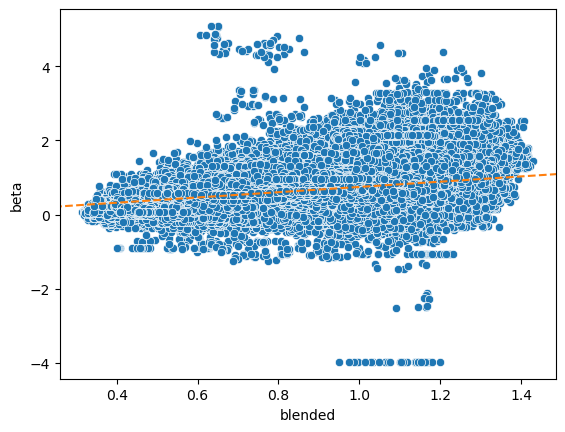

In [66]:
holdout_predictions = pd.DataFrame(columns = model_names, index = y_holdout.index)
holdout_metrics = pd.DataFrame(index = metrics_df.index, columns =metrics_df.columns)
for key in xgb_models.keys():
    model = xgb_models[key]
    ypred = model.predict(X_holdout)
    holdout_predictions[key] = ypred

    holdout_metrics.loc['rmse', key] = mean_squared_error(ypred, y_holdout, squared=False)
    holdout_metrics.loc['mae', key] = mean_absolute_error(ypred, y_holdout)
    holdout_metrics.loc['pearson_r', key] = pearsonr(ypred, y_holdout)[0]
    holdout_metrics.loc['spearman_r', key] = spearmanr(ypred, y_holdout)[0]

holdout_metrics.loc['pearson_weight']= holdout_metrics.loc['pearson_r']/holdout_metrics.loc['pearson_r'].sum()
display(holdout_metrics)

holdout_predictions['blended'] = (holdout_predictions*holdout_metrics.loc['pearson_weight']).sum(axis=1)

fig, ax = plt.subplots()

sns.scatterplot(x=holdout_predictions['blended'],y= y_holdout)
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([y.min(), y.max()], [y_holdout.min(), y_holdout.max()], '--',color = 'tab:orange')

In [67]:
pearsonr(holdout_predictions['blended'], y_holdout)

PearsonRResult(statistic=0.5717858148114267, pvalue=0.0)

# Analyze a few time series

In [79]:
sec_stats[sec_stats['beta_rank'] <2000]

,avg_alpha,alpha_rank,avg_beta,beta_rank
Code,,,,
7280,-0.001158,127.0,1.728782,1.0
6407,0.000475,645.0,1.707516,2.0
6619,0.000017,1815.0,1.703060,3.0
6444,-0.001473,56.0,1.697806,4.0
7732,-0.000035,1760.0,1.685028,5.0
...,...,...,...,...
9537,-0.000115,1531.0,0.061468,1862.0
2268,-0.000243,1165.0,0.059382,1863.0
2226,-0.000021,1806.0,0.054279,1864.0


In [81]:
ticker = 9539
df = pd.concat([train, holdout_predictions], axis = 1).loc[idx[ticker, str(holdout)]]

<Axes: xlabel='Date', ylabel='beta'>

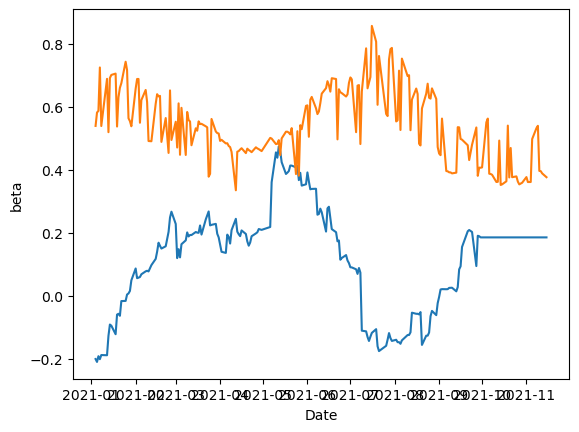

In [82]:
fig, ax = plt.subplots()

sns.lineplot(df, x = 'Date', y= 'beta', ax = ax)
sns.lineplot(df, x = 'Date', y = 'blended', ax = ax)